# 1. Импорт библиотек и объявление функций

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import learning_curve, validation_curve

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline


In [2]:
# Глобальные переменные
RANDOM_SEED = 42
MAX_ITER = 1000

# Хранилище результатов подбора гиперпараметров для модели
metrics = pd.DataFrame(columns=['model','param','TP','TN','FP','FN', 
                              'accuracy','balanced_accuracy', 'precision','recall','f1','roc_auc'])

# Папки для скачивания исходных файлов и загрузки результата
dir_in = '/kaggle/input/sf-dst-scoring/'
dir_out = '/kaggle/output/'
dir_dollar = '/kaggle/input/addinfo/'

In [3]:
# Функции 

# Определение выбросов
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col], Q1 - 1.5*IQR, Q3 + 1.5*IQR

# Преобразование в None для строковых признаков
def set_None(value):
    if value is None:
        return value
    else:
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value

# Добавление оценок для очередной модели
def add_model_metrics(metrics, model_name, model_param, y_true, y_pred, y_pred_prob):
    
    df_model = metrics[metrics['model']== model_name]
    if len(df_model) > 0:
        metrics = metrics[metrics['model']!= model_name]
        
    TP = np.sum((y_true==1) & (y_pred==1))
    TN = np.sum((y_true==0) & (y_pred==0))
    FP = np.sum((y_true==0) & (y_pred==1))
    FN = np.sum((y_true==1) & (y_pred==0))
    
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred) 
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)    

    metrics.loc[len(metrics)] = [model_name, model_param, TP, TN, FP, FN, 
                              accuracy, balanced_accuracy, precision, recall, f1, roc_auc] 
    return metrics
    
# Визуализация результатов модели
def graph_roc_auc(y_true, y_pred_prob):
    # ROC AUC кривая
    fpr, tpr, threshold = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
 
    plt.figure(figsize=(4, 4))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    

def graph_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(cm) / float(np.sum(cm))
    
    cmap = plt.get_cmap('Wistia')
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    
    target_names = ['non default', 'default']
    title_names = ['N', 'P']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    cm_norm = cm.astype('float') * 100 / cm.sum(axis=1)[:, np.newaxis]


    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        title = '!'
        if i==j:
            title = 'T' + title_names[j]
        else:
            title = 'F' + title_names[j]
          
        plt.text(j, i, title+"\n"+"{0}".format(cm[i, j])+"\n"+"{:1.2f}".format(cm_norm[i, j])+"%" ,
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True values')
    plt.xlabel('Predicted values: accuracy={:0.4f}'.format(accuracy))
    plt.show()
    
    
def show_info(df, col):
    # Выводим количество выбросов и их границы
    out, lim1, lim2 = get_outlier(df, col)
    minCol = df[col].min()
    maxCol = df[col].max()
    median = df[col].median()
    
    cnt = min(int(df[col].value_counts().count()),2000)
    
    print('Минимум: ', minCol)
    print('Максимум: ', maxCol)
    print('Медиана: ', median)
    print('Количество выбросов: ', len(out))
    if len(out) > 0:
        print('Нижняя граница выбросов: ', lim1)
        print('Верхняя граница выбросов: ', lim2)
    
    # Выводим графики: гистограмму и боксплот
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].hist(df[col], bins=cnt)
    axes[1].boxplot(df[col])
    
    return {'med': median, 'lm1': lim1, 'lm2': lim2}

# 2. Чтение данных

In [4]:
# Тестовый набор
df_test = pd.read_csv('test.csv') # pd.read_csv(dir_in + 'test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [5]:
# Тренировочный набор
df_train = pd.read_csv('train.csv') # pd.read_csv(dir_in + 'train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
# Дополнительный набор из внешних источников
df_dollar = pd.read_csv('dollar.csv') # pd.read_csv(dir_dollar + 'dollar.csv')
df_dollar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dt      120 non-null    object 
 1   rate    120 non-null    float64
 2   infl    120 non-null    float64
 3   srf     120 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.9+ KB


In [7]:
# Добавляем признак для разделения тренировочной и тестовой части
df_train['sample'] = 1 
df_test['sample'] = 0 

# В тестовой части добавляем признак с целевой переменной 
df_test['default'] = 0 

# Объединяем части
df = df_test.append(df_train, sort=False).reset_index(drop=True)

In [8]:
# Смотрим на состав данных и заполнение полей
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [9]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


# 3. Обработка данных

## 3.1 Целевая переменная default

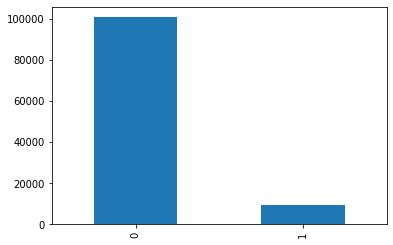

In [10]:
# Целевая переменная. Смотрим на ее распределение
df['default'].value_counts().plot.bar()

Вывод: переменная распределена очень неравномерно. 
При построении модели, наверное, надо будет прибегать к балансировке

## 3.2 Признак client_id

In [11]:
# Проверим уникальность
df['client_id'].value_counts()

2047     1
97541    1
93447    1
70920    1
72969    1
        ..
47810    1
45763    1
35524    1
33477    1
2049     1
Name: client_id, Length: 110148, dtype: int64

Столбец имеет только уникальные значения и может служить идентификатором записи

## 3.3 Признак education

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

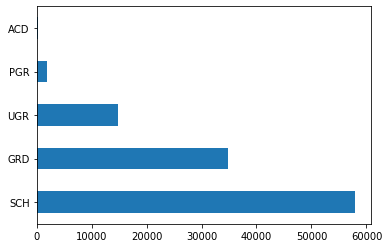

In [12]:
display(df['education'].value_counts())
df['education'].value_counts().plot.barh()

SCH    58408
GRD    34821
UGR    14757
PGR     1867
ACD      295
Name: education, dtype: int64

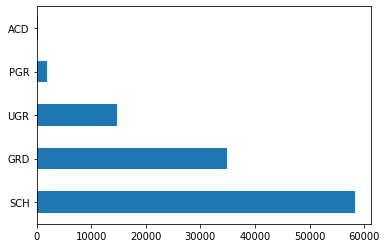

In [13]:
# Столбец имеет пропуски.
# Их можно заполнить самым частым значением SCH, но можно равномерно нарастить количество каждых значений
# Попробуем заполнить значениями в зависимости от других параметров
df['education'] = df['education'].apply(set_None)

df['education'] = df.apply(
    lambda row : row['education'] if  not (row['education'] is None) \
    else 'ACD' if row['good_work']==1 and row['car_type']=='Y' and row['foreign_passport']=='Y' and row['income']>50000 \
    else 'PGR' if row['good_work']==1 and row['car_type']=='Y' and row['foreign_passport']=='Y' \
    else 'UGR' if row['good_work']==1 and row['foreign_passport']=='Y' \
    else 'GRD' if row['good_work']==1 \
    else 'SCH', axis = 1)

display(df['education'].value_counts())

df['education'].value_counts().plot.barh()

In [14]:
# Это категориальный признак, но в нем явно градуируются уровни образования
# Добавим столбец с числовыми значениями
education = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
df['edu'] = df['education'] 
df['education'] = df['education'].map(education)
df['edu'] = df['edu'].map(education)

In [15]:
# Создадим список столбцов, которые не надо будет преобразовывать.
# Пока в него внесем только education
dop_cols = ['education']

# А дополнительный столбец для преобразования в dummy пока просто сохраним в списке категориальных столбцов
cat_cols = ['edu']

## 3.4 Бинарные признаки

In [16]:
# Занесем все бинарные признаки в список
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [17]:
# Проверим, какие значения они принимают
for col in bin_cols:
    display(df[col].value_counts())

F    61836
M    48312
Name: sex, dtype: int64

N    74290
Y    35858
Name: car, dtype: int64

N    89140
Y    21008
Name: car_type, dtype: int64

0    91917
1    18231
Name: good_work, dtype: int64

N    93721
Y    16427
Name: foreign_passport, dtype: int64

In [18]:
# Превратим их в числовые значения 0 и 1
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    
df.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,edu
0,74835,22MAR2014,2,1,29,1,1,0,0,-2.271884,...,50,1,2,50000,1,4,0,0,0,2
1,17527,24JAN2014,1,0,39,0,0,5,0,-1.504999,...,50,1,2,5000,4,3,0,0,0,1


## 3.5 Признак age

Минимум:  21
Максимум:  72
Медиана:  37.0
Количество выбросов:  0


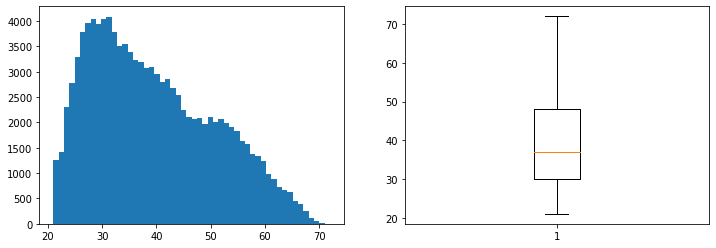

In [19]:
# Проверим распределение
d = show_info(df,'age')

In [20]:
# По первому графику видно, что выделяются 3 категории заемщиков: до 25 лет,  после 50 и все остальные
# Создадим дополнительный признак с возрастными категориями и запомним его в списке доп.столбцов
df['cat_age'] = df['age'].apply(lambda x: 0 if x<25 else 2 if x>50 else 1)
dop_cols.append('cat_age')

In [21]:
# У признака большой разброс в значениях. Прологарифмируем
df['age'] = np.log(df['age'])

Минимум:  3.044522437723423
Максимум:  4.276666119016055
Медиана:  3.6109179126442243
Количество выбросов:  0


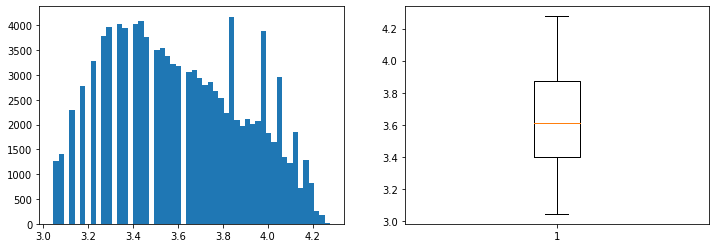

In [22]:
# Снова проверим распределение
d = show_info(df,'age')

Распределение логарифма от возраста стало более нормальным.
К основному признаку добавили признак с категориями возрастов: очень молодой, средний, зрелый

## 3.6 Признак decline_app_cnt

Минимум:  0
Максимум:  33
Медиана:  0.0
Количество выбросов:  18677
Нижняя граница выбросов:  0.0
Верхняя граница выбросов:  0.0


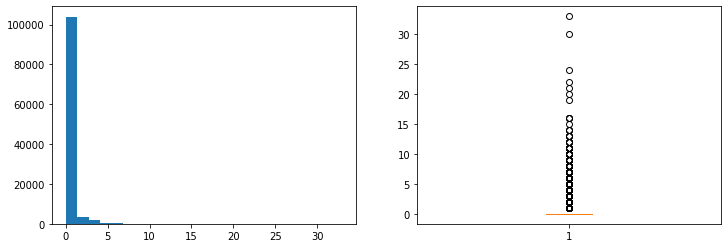

In [23]:
# Проверим распределение
d = show_info(df,'decline_app_cnt')

In [24]:
# Посмотрим на количество
df.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

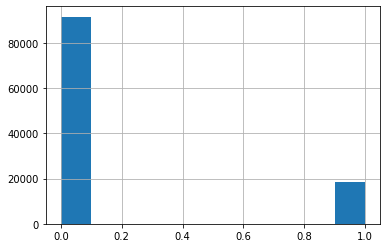

In [25]:
# Выбросами являются все ненулевые значения. Выделим их в отдельную колонку
# Сделаем из этого столбца бинарный признак отказов
df['cat_decline'] = df.decline_app_cnt.apply(lambda x: 0 if x==0 else 1)
bin_cols.append('cat_decline')
df['cat_decline'].hist()

In [26]:
# Прологарифмируем, поскольку разброс большой
df['decline_app_cnt'] = np.log(df['decline_app_cnt']+1)

Минимум:  0.0
Максимум:  3.5263605246161616
Медиана:  0.0
Количество выбросов:  18677
Нижняя граница выбросов:  0.0
Верхняя граница выбросов:  0.0


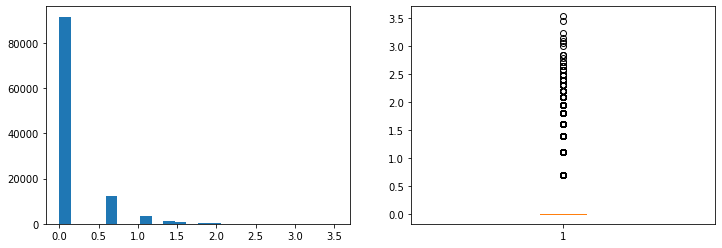

In [27]:
# Проверим распределение после логарифмирования
d = show_info(df,'decline_app_cnt')

Распределение decline_app_cnt - логнормальное. Очень много выбросов - все ненулевые значения являются выбросами.
Очищать от выбросов нецелесообразно. Вместо этого все выбросы объединили в отдельную категорию.

## 3.7 Признак bki_request_cnt

Минимум:  0
Максимум:  53
Медиана:  1.0
Количество выбросов:  2636
Нижняя граница выбросов:  -4.5
Верхняя граница выбросов:  7.5


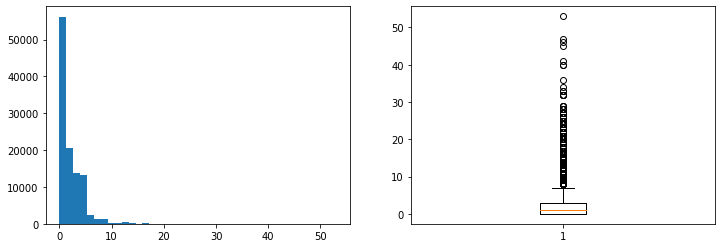

In [28]:
# Проверим распределение
d = show_info(df,'bki_request_cnt')

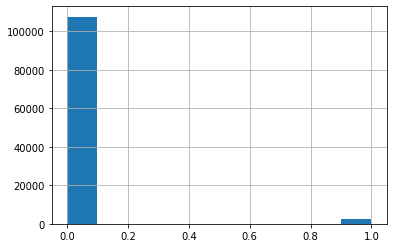

In [29]:
# Создадим столбец с выбросами
df['bki_out'] = df['bki_request_cnt'].apply(lambda x: 1 if x>d['lm2'] or x<d['lm1'] else 0)
bin_cols.append('bki_out')
df['bki_out'].hist()

Минимум:  0.0
Максимум:  3.9889840465642745
Медиана:  0.6931471805599453
Количество выбросов:  15
Нижняя граница выбросов:  -2.0999999999999996
Верхняя граница выбросов:  3.4862943611198904


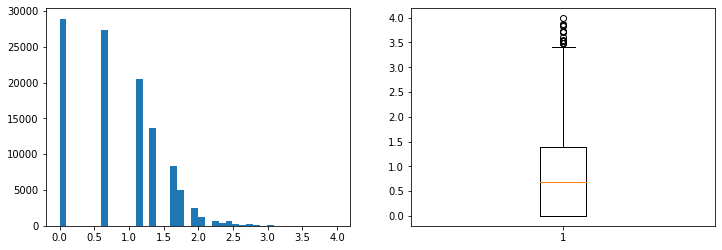

In [30]:
# Большой разброс значений. Прологарифмируем и снова посмотрим на распределение
df['bki_request_cnt'] = np.log(df['bki_request_cnt']+1)
d = show_info(df,'bki_request_cnt')

Минимум:  0.0
Максимум:  3.4011973816621555
Медиана:  0.6931471805599453
Количество выбросов:  0


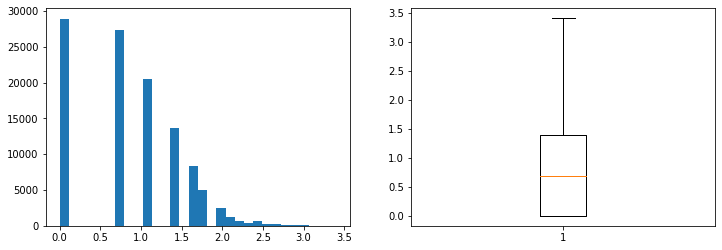

In [31]:
# После логарифмирования осталось всего 15 выбросов.
# Заменим их на медиану и проверим распределение
df['bki_request_cnt'] = df['bki_request_cnt'].apply(lambda x: d['med'] if x>d['lm2'] or x<d['lm1'] else x)
d = show_info(df,'bki_request_cnt')

Распределение bki_request_cnt - логнормальное. Выбросов немного. Их заменили медианой.

## 3.8 Признак income

Минимум:  1000
Максимум:  1000000
Медиана:  30000.0
Количество выбросов:  7000
Нижняя граница выбросов:  -22000.0
Верхняя граница выбросов:  90000.0


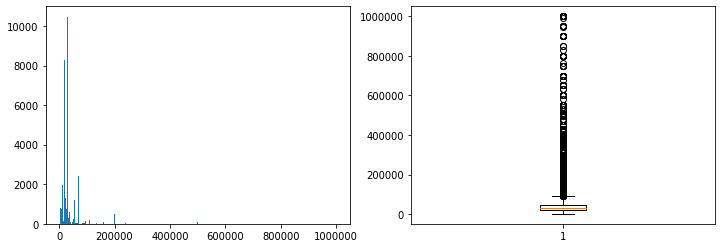

In [32]:
d = show_info(df,'income')

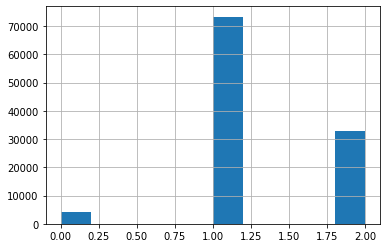

In [33]:
# Выделим 3 категории дохода
df['cat_income'] = df['income'].apply(lambda x: 0 if x<10000 else 2 if x>40000 else 1)
df['cat_income'].hist()

Минимум:  6.907755278982137
Максимум:  13.815510557964274
Медиана:  10.308952660644293
Количество выбросов:  2429
Нижняя граница выбросов:  8.553487552536128
Верхняя граница выбросов:  12.128956289890027


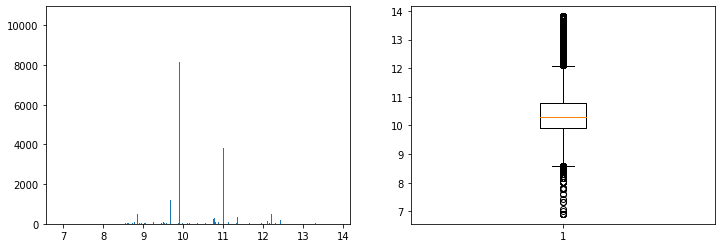

In [34]:
# Большой разброс значений. Прологарифмируем и снова посмотрим на выбросы
df['income'] = np.log(df['income'])
d = show_info(df,'income')

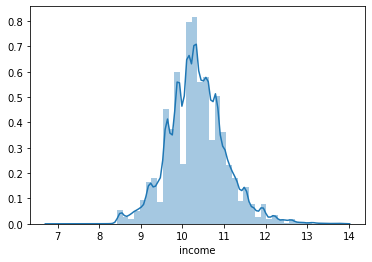

In [35]:
# Посмотрим распределение на более информативном графике
sns_plot = sns.distplot(df['income'])
fig = sns_plot.get_figure()

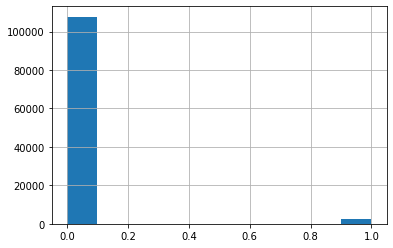

In [36]:
# Создадим столбец с выбросами
df['income_out'] = df['income'].apply(lambda x: 1 if x>d['lm2'] or x<d['lm1'] else 0)
df['income_out'].hist()

In [37]:
# Распределение отдаленно стало похоже на нормальное
# Но выбросов все равно много, оставим их все.

# Столбец с категориями доходов внесем в отдельный список
dop_cols.append('cat_income')

# Столбец с выбросами - в другой список
bin_cols.append('income_out')

Распределение income - логнормальное. Очень много выбросов, их преобразовывать не стали.
Доходы разделили на части и выделили в отдельные категории.

## 3.9 Признак app_date

In [38]:
# Превратим строковый столбец в столбец с датами и посмотрим на разброс значений
df['app_date_dt'] = df['app_date'].apply(lambda x: datetime.strptime(x,'%d%b%Y'))
df['app_date_dt'].sort_values()

32219    2014-01-01
48827    2014-01-01
99141    2014-01-01
14209    2014-01-01
100585   2014-01-01
            ...    
91400    2014-04-30
80416    2014-04-30
50524    2014-04-30
20299    2014-04-30
42268    2014-04-30
Name: app_date_dt, Length: 110148, dtype: datetime64[ns]

Все значения лежат в интервале от 1 января до 30 апреля включительно.

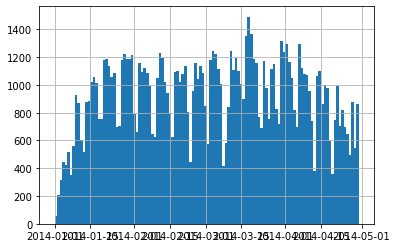

In [39]:
# Проверим распределение
date_cnt = int(df['app_date_dt'].value_counts().count())
df['app_date_dt'].hist(bins=date_cnt)

In [40]:
# Добавим признак с количеством дней от начала года
min_date = df['app_date_dt'].min()  
df['app_date_days'] = df['app_date_dt'].apply(lambda x: (x - min_date).days)

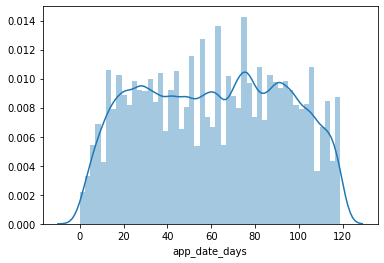

In [41]:
# Проверим его распределение
sns_plot = sns.distplot(df['app_date_days'])
fig = sns_plot.get_figure()

In [42]:
df['app_date_days'].value_counts().head(24)

76    1491
77    1363
75    1350
89    1317
96    1296
91    1291
69    1245
62    1242
90    1239
41    1233
27    1226
63    1221
30    1216
71    1194
42    1193
20    1189
29    1187
78    1185
28    1184
19    1182
26    1177
61    1177
82    1173
92    1168
Name: app_date_days, dtype: int64

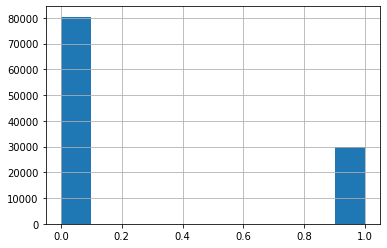

In [43]:
# По графику видно, что выделяются отдельные дни, когда обращений было особенно много
# Выделим группы дней с наибольшим количеством обращений (80% по Парето) и всеми остальными
# Наиболее частых: 120*0.2=24 штуки
lstMax = list(df['app_date_days'].value_counts().index[:24])
df['app_days_top'] = df['app_date_days'].apply(lambda x: 1 if x in lstMax else 0) 
df['app_days_top'].hist()

In [44]:
# Столбец с днями удалим, он очень неравномерно распределен
df = df.drop(['app_date_days'], axis=1)

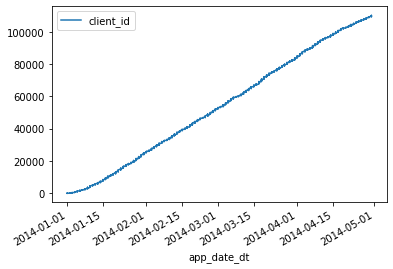

In [45]:
# Проверим, не зависят ли номера клиентов от даты
df.plot(x='app_date_dt', y='client_id')
plt.show()

Видно, что номера идут равномерно в зависимости от даты.
Скорее всего, клиентов нумеруют по порядку обращения.
Эта информация интересная, но нужна ли она - непонятно.

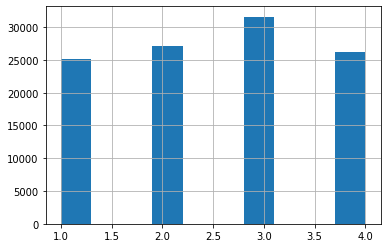

In [46]:
# Кредиты в разные месяцы берут по-разному: перед дачным сезоном реже, осенью и зимой - чаще
# Добавим столбец с месяцем обращения за кредитом
df['app_month'] = df['app_date_dt'].apply(lambda x: x.month)
df['app_month'].hist()

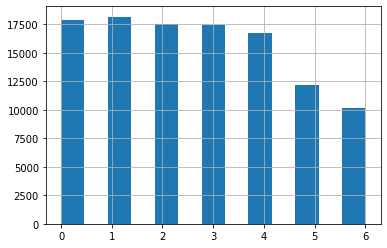

In [47]:
# В конце недели кредиты берут реже. Добавим день недели обращения
df['app_week'] = df['app_date_dt'].apply(lambda x: x.weekday())
df['app_week'].hist(bins=13)

In [48]:
# Выделяются выходные. Создадим для них отдельный признак
df['app_wend'] = df['app_week'].apply(lambda x: 1 if x==5 or x==6 else 0) 
df['app_wend'].value_counts()

0    87789
1    22359
Name: app_wend, dtype: int64

In [49]:
# В праздничные дни берут реже. Добавим признак праздника или не праздника
# и объединим с выходными днями
holiday = df['app_date_dt'].unique()
holiday.sort()
hol = holiday[0:8]
hol = np.append(hol, holiday[53])
hol = np.append(hol, holiday[66:69])
print(hol)
df['app_hol'] = df['app_date_dt'].apply(lambda x: 1 if x in hol else 0) 
df['app_hol'].value_counts()

['2014-01-01T00:00:00.000000000' '2014-01-02T00:00:00.000000000'
 '2014-01-03T00:00:00.000000000' '2014-01-04T00:00:00.000000000'
 '2014-01-05T00:00:00.000000000' '2014-01-06T00:00:00.000000000'
 '2014-01-07T00:00:00.000000000' '2014-01-08T00:00:00.000000000'
 '2014-02-23T00:00:00.000000000' '2014-03-08T00:00:00.000000000'
 '2014-03-09T00:00:00.000000000' '2014-03-10T00:00:00.000000000']


0    104990
1      5158
Name: app_hol, dtype: int64

In [50]:
# Объединим праздники с выходными
df['app_hol'] = df['app_hol'] + df['app_wend']
df['app_hol'] = df.apply(
    lambda row : 1 if  row['app_hol']==1 or row['app_wend']==1 else 0, axis = 1)

In [51]:
# Удалим отработавший столбец с выходными и посмотрим итоговое распределение
df = df.drop(['app_wend'], axis=1)
df['app_hol'].value_counts()

0    84946
1    25202
Name: app_hol, dtype: int64

In [52]:
# Добавляем данные с курсом доллара, уровнем инфляции и ставкой рефинансирования РФ
df_dollar = df_dollar.rename(columns={'dt': 'app_date_dt'})
df_dollar['app_date_dt'] = df_dollar['app_date_dt'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df = df.join(df_dollar.set_index('app_date_dt'), on='app_date_dt')
df.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,cat_income,income_out,app_date_dt,app_days_top,app_month,app_week,app_hol,rate,infl,srf
0,74835,22MAR2014,2,1,3.367296,1,1,0.000000,0,-2.271884,...,2,0,2014-03-22,0,3,5,1,36.4022,6.92,7.0
1,17527,24JAN2014,1,0,3.663562,0,0,1.791759,0,-1.504999,...,0,1,2014-01-24,0,1,4,0,34.0334,6.05,5.5
2,75683,23MAR2014,3,1,3.912023,1,1,0.000000,0,-1.691339,...,1,0,2014-03-23,0,3,6,1,36.4022,6.92,7.0
3,26883,03FEB2014,1,1,4.025352,0,0,0.000000,0,-2.374182,...,1,0,2014-02-03,0,2,0,0,35.1800,6.20,5.5
4,28862,04FEB2014,2,0,3.637586,0,0,0.000000,0,-2.487502,...,2,0,2014-02-04,0,2,1,0,35.2347,6.20,5.5


In [53]:
# Курс доллара стандартизируем
# min_rate = df['rate'].min()
# max_rate = df['rate'].max()
# df['rate'] = (df['rate'] - min_rate)/(max_rate-min_rate)
# df['rate'].head(2)

# Курс доллара сдвигаем на минимум
min_rate = df['rate'].min()
df['rate'] = df['rate'] - min_rate
df['rate'].head(5)

0    3.7435
1    1.3747
2    3.7435
3    2.5213
4    2.5760
Name: rate, dtype: float64

In [54]:
# Внесем новые столбцы в списки
bin_cols.append('app_hol')
bin_cols.append('app_days_top')
cat_cols.append('app_week')
cat_cols.append('app_month')

Столбец с номерами клиентов прямо зависит от дат обращения.
Из столбца с датами извлекли группу частых дней обращений, месяц, день недели и признак праздничного дня.

## 3.10 Признак score_bki

Минимум:  -3.62458632
Максимум:  0.19977285
Медиана:  -1.92082293
Количество выбросов:  482
Нижняя граница выбросов:  -3.3104407399999998
Верхняя граница выбросов:  -0.5178840650000001


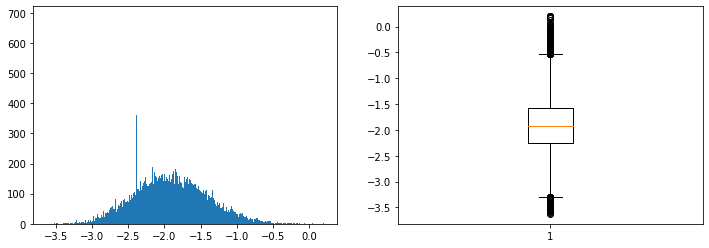

In [55]:
# Проверим распределение
d = show_info(df,'score_bki')

Распределение нормальное
Разброс значений небольшой, поэтому логарифмировать не обязательно.

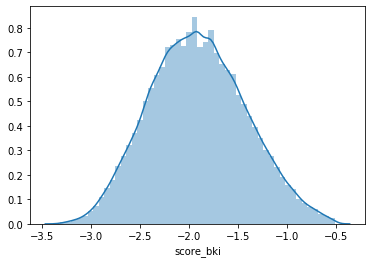

In [56]:
# Выбросов не очень много. Заменим их медианой
df['score_bki'] = df['score_bki'].apply(lambda x: d['med'] if x>d['lm2'] or x<d['lm1'] else x)
sns_plot = sns.distplot(df['score_bki'])
fig = sns_plot.get_figure()

Распределение стало нормальным, значит, этот признак качественно отработает в модели.

## 3.11 Первичные категориальные признаки

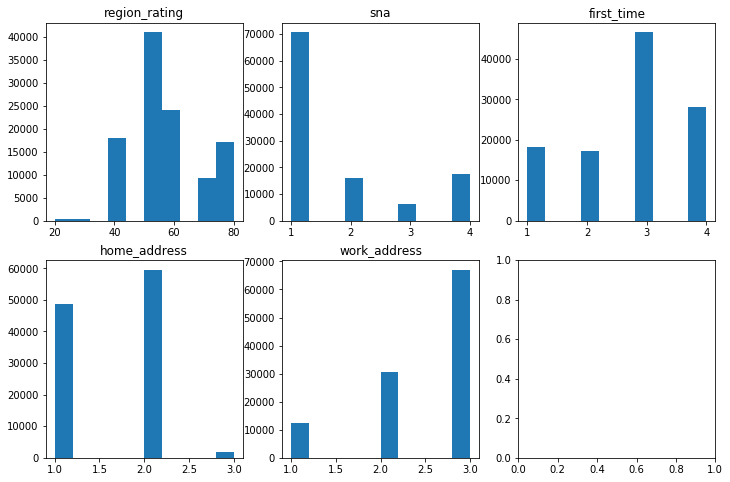

In [57]:
# Проверим распределение
fig, axes = plt.subplots(2,3,figsize=(12,8))
axes[0,0].hist(df['region_rating'])
axes[0,0].set_title('region_rating')
axes[0,1].hist(df['sna'])
axes[0,1].set_title('sna')
axes[0,2].hist(df['first_time'])
axes[0,2].set_title('first_time')
axes[1,0].hist(df['home_address'])
axes[1,0].set_title('home_address')
axes[1,1].hist(df['work_address'])
axes[1,1].set_title('work_address')
fig.show()

In [58]:
# Признаки категориальные. Занесем их в список
cat_cols.append('home_address')
cat_cols.append('work_address')
cat_cols.append('region_rating')
cat_cols.append('sna')
cat_cols.append('first_time')

In [59]:
# Как потом станет видно, у признака region_rating для регионов 70 и 80 - сильная отрицательная корреляция,
# а для прочих - неотрицательная
# Сделаем новый бинарный признак: регион 70 или 80 и все остальные
df['reg_7080'] = df['region_rating'].apply(lambda x: 1 if x==80 or x==70 else 0) 
bin_cols.append('reg_7080')
df['reg_7080'].value_counts()

0    83674
1    26474
Name: reg_7080, dtype: int64

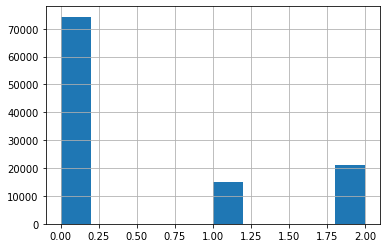

In [60]:
# Сделаем дополнительную категориальную переменную: автомобиль + его тип
df['cat_car'] = df.apply(
    lambda row : 0 if  row['car']==0 and row['car_type']==0 \
    else 1 if row['car']==1 and row['car_type']==0 \
    else 2, axis = 1)
cat_cols.append('cat_car')
df['cat_car'].hist()

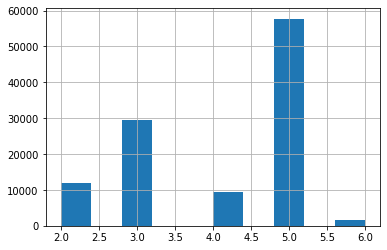

In [61]:
# Сделаем дополнительную категориальную переменную: домашний адрес + рабочий адрес 
# Здесь исходим из того, что у двух адресов один категоризатор. Но это только предположение.
df['cat_addr'] = df['home_address'] + df['work_address']
cat_cols.append('cat_addr')
df['cat_addr'].hist()

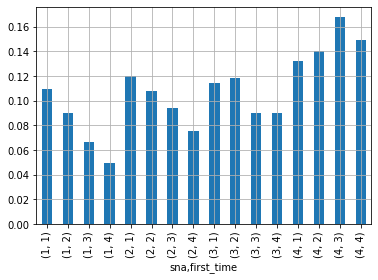

In [62]:
# Посмотрим на выдачу кредита в зависимости от двух параметров: sna и first_time
df.groupby(by = ['sna', 'first_time'])['default'].mean().plot(kind = 'bar', grid= True)

In [63]:
# Сделаем дополнительную переменную: sna-first_time 
df['cat_sf'] = df['sna'] - df['first_time']
df['cat_sf'] = df['cat_sf'].apply(lambda x: 1 if x>0 else 0) 
bin_cols.append('cat_sf')
df['cat_sf'].value_counts()

0    87335
1    22813
Name: cat_sf, dtype: int64

## 3.12 Проверка корреляции и важности признаков

In [64]:
# Проверка столбцов
num_cols = ['age','decline_app_cnt','bki_request_cnt','income','score_bki','rate','infl','srf']
cat_cols, bin_cols, dop_cols

(['edu',
  'app_week',
  'app_month',
  'home_address',
  'work_address',
  'region_rating',
  'sna',
  'first_time',
  'cat_car',
  'cat_addr'],
 ['sex',
  'car',
  'car_type',
  'good_work',
  'foreign_passport',
  'cat_decline',
  'bki_out',
  'income_out',
  'app_hol',
  'app_days_top',
  'reg_7080',
  'cat_sf'],
 ['education', 'cat_age', 'cat_income'])

In [65]:
# Категории возраста, выброса доходов и дохода тоже внесем в категориальные признаки
cat_cols.append('cat_age')
cat_cols.append('cat_income')

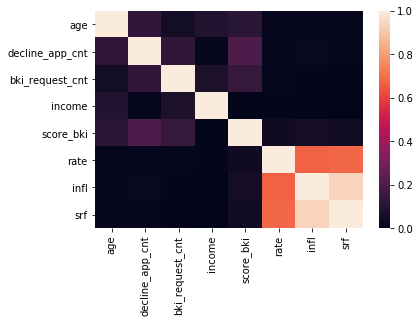

In [66]:
# Посмотрим на корреляцию числовых признаков:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

In [67]:
# Видно, что у коэффициента инфляции, курса доллара и ставки рефинансирования очень сильная корреляция
# Удалим столбец с уровнем инфляции
df = df.drop(['infl'], axis=1)
num_cols.remove('infl')

Сильной корреляции между остальными числовыми признаками нет. Их все можно брать для построения модели.
Некоторая корреляция наблюдается между банковским рейтингом и количеством отказов от кредита.
Скорее всего, этот рейтинг уже учитывает те обстоятельства, из-за которых были отказы.

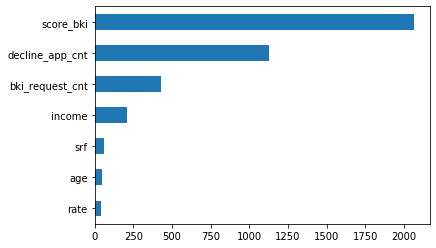

In [68]:
# Проверим значимость признаков с непрерывными значениями по тесту ANOVA
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самый значимый признак - это оценка клиента от банков, а возраст и курс доллара - самые малозначительные признаки.
Убирать их пока не будем. Проверим их потом другими методами после построения модели.

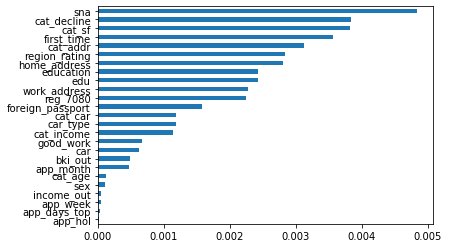

In [69]:
# Проверим значимость признаков с дискретными значениями
imp_cat = Series(mutual_info_classif(df[set(bin_cols + cat_cols + dop_cols)], df['default'],
                                     discrete_features =True), index = set(bin_cols + cat_cols+ dop_cols))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самый значимый признак - таинственный sna.
Малозначимые признаки примем на заметку и при необходимости удалим после построения модели

## 3.13 Dummy-признаки

In [70]:
# Превратим категориальные переменные в dummy
df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 76 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  object        
 2   education         110148 non-null  int64         
 3   sex               110148 non-null  int32         
 4   age               110148 non-null  float64       
 5   car               110148 non-null  int32         
 6   car_type          110148 non-null  int32         
 7   decline_app_cnt   110148 non-null  float64       
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  float64       
 11  income            110148 non-null  float64       
 12  foreign_passport  110148 non-null  int32         
 13  sample            110148 non-null  int64         
 14  defa

## 3.14 Подготовка данных для модели

In [71]:
# Удалим нечисловые столбцы и client_id
df = df.drop(['client_id', 'app_date', 'app_date_dt'], axis=1)
data = df.copy()

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 73 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  int64  
 1   sex               110148 non-null  int32  
 2   age               110148 non-null  float64
 3   car               110148 non-null  int32  
 4   car_type          110148 non-null  int32  
 5   decline_app_cnt   110148 non-null  float64
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  float64
 9   income            110148 non-null  float64
 10  foreign_passport  110148 non-null  int32  
 11  sample            110148 non-null  int64  
 12  default           110148 non-null  int64  
 13  cat_decline       110148 non-null  int64  
 14  bki_out           110148 non-null  int64  
 15  income_out        110148 non-null  int64  
 16  app_days_top      11

In [73]:
# Разобьем данные на тренировочные и тестовые
train = df[df['sample']==1].drop(['sample'], axis=1)
test = df[df['sample']==0].drop(['sample'], axis=1)

In [74]:
# Матрица признаков и столбец целевой переменной
X = train.drop(['default'], axis=1) 
y = train['default']

# 4. Построение модели

## 4.1 Модель без параметров

In [75]:
# Модель LogisticRegression №1 без параметров: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

model1 = LogisticRegression(random_state=RANDOM_SEED)
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

probs = model1.predict_proba(X_test)
y_pred_prob = probs[:,1]

metrics = add_model_metrics(metrics, 'm1', [], y_test, y_pred, y_pred_prob)
metrics

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m1,[],39,12865,68,1788,0.874255,0.508044,0.364486,0.021346,0.040331,0.745033


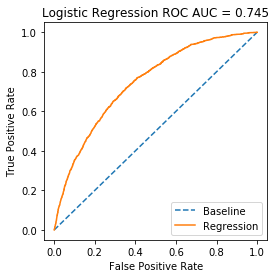

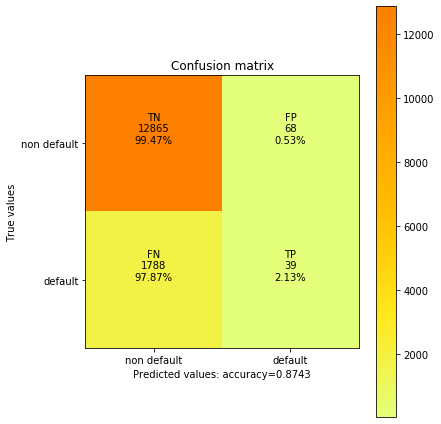

In [76]:
graph_roc_auc(y_test, y_pred_prob)
graph_confusion_matrix(y_test, y_pred)

Метрика f1 очень плохая. Модель слишком часто отказывает в кредите.

## 4.2 Модель с балансировкой

In [77]:
# Запускаем GridSearch на итерациях max_iter=100 и с штатной дельтой останова tol = 0.0001
# Спасибо неизвестному автору за идею такого поиска

model = LogisticRegression(random_state=RANDOM_SEED)
iteration = 100
stop = 0.0001
parameters = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iteration],
     'tol':[stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iteration],
     'tol':[stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iteration],
     'tol':[stop]},
    {'penalty': ['elasticnet'], 
     'solver': ['saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iteration],
     'tol':[stop]},
]
gridsearch = GridSearchCV(model, parameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

# Выводим параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
        
# Выводим метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy: 0.6713
Precision: 0.2279
Recall: 0.6935
F1: 0.3431


In [78]:
# Видно, что выбрана модель с балансировкой.
# Это ожидалось, так как распределение значений очень неравномерное
# Добавим одну только балансировку и проверим, как она повлияла
model2 = LogisticRegression(class_weight='balanced', 
                           random_state=RANDOM_SEED,
                           max_iter=MAX_ITER)

model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

probs = model2.predict_proba(X_test)
probs = probs[:,1]

metrics = add_model_metrics(metrics, 'm2', ['class_weight=balanced'], y_test, y_pred, y_pred_prob)
metrics

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m1,[],39,12865,68,1788,0.874255,0.508044,0.364486,0.021346,0.040331,0.745033
1,m2,[class_weight=balanced],1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033


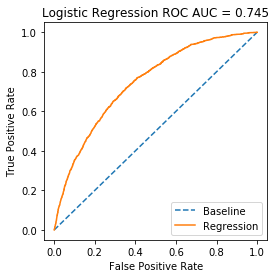

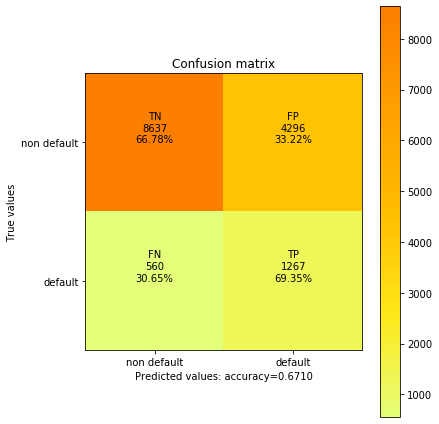

In [79]:
graph_roc_auc(y_test, y_pred_prob)
graph_confusion_matrix(y_test, y_pred)

Train ROC AUC: mean=0.7499, std=0.0016
Test ROC AUC: mean=0.7395, std=0.0141


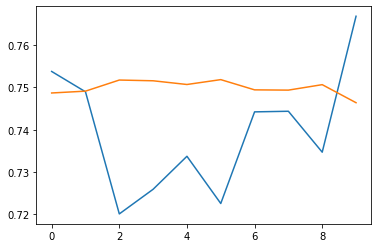

In [80]:
# Проведем кросс-валидацию модели
temp_vec = cross_validate(model2, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)

arr_test = temp_vec['test_score']
arr_train = temp_vec['train_score']

print('Train ROC AUC: mean={:0.4f}'.format(np.mean(arr_train)) + ", std={:1.4f}".format(np.std(arr_train))) 
print('Test ROC AUC: mean={:0.4f}'.format(np.mean(arr_test)) + ", std={:1.4f}".format(np.std(arr_test))) 

plt.plot(range(10),temp_vec['test_score'])
plt.plot(range(10),temp_vec['train_score'])

Видно, что модель на разных разбиениях ведет себя не очень стабильно.
Это значит, что, скорее всего, на тестовой выборке результат будет хуже, чем на тренировочной.

Балансировка резко улучшила оценку f1 и balanced_accuracy. ROC AUC осталась такой же

## 4.3 Модели с регуляризацией

In [81]:
# Попробуем поискать другие гиперпараметры.
# Параметр dual менять не будем. Он по умолчанию = False и в документации говорится:
#    "Prefer dual=False when n_samples > n_features"
# Параметр fit_intercept тоже менять не будем, он тоже по умолчанию = True
# Параметр multi_class тоже не трогаем, потому что разбиваем на 2 класса и в таком случае auto = ovr

# Попробуем к балансировке добавить регуляризацию l1 и пробежаться по разным ее коэффициентам
arr_C = [0.001, 0.01, 0.1, 1, 10, 100]
arr_solver = ['liblinear', 'saga']
i = 3

for C_val in arr_C:
    for solver_val in arr_solver:
        model = LogisticRegression(C=C_val, 
                                   penalty='l1', 
                                   class_weight='balanced', 
                                   solver=solver_val, 
                                   random_state=RANDOM_SEED,
                                   max_iter=MAX_ITER)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        probs = model.predict_proba(X_test)
        probs = probs[:,1]
        
        metrics = add_model_metrics(metrics, 'm' + str(i), 
                         ['class_weight=balanced', 'penalty=l1', 'C='+str(C_val), 'solver='+ str(solver_val)], 
                         y_test, y_pred, y_pred_prob)
        
        i += 1

metrics

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m1,[],39,12865,68,1788,0.874255,0.508044,0.364486,0.021346,0.040331,0.745033
1,m2,[class_weight=balanced],1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
2,m3,"[class_weight=balanced, penalty=l1, C=0.001, s...",1174,8698,4235,653,0.668835,0.657563,0.217046,0.642583,0.324489,0.745033
3,m4,"[class_weight=balanced, penalty=l1, C=0.001, s...",1183,8389,4544,644,0.648509,0.648080,0.206565,0.647510,0.313212,0.745033
4,m5,"[class_weight=balanced, penalty=l1, C=0.01, so...",1255,8676,4257,572,0.672832,0.678880,0.227685,0.686918,0.342008,0.745033
5,m6,"[class_weight=balanced, penalty=l1, C=0.01, so...",1256,8634,4299,571,0.670054,0.677530,0.226103,0.687466,0.340287,0.745033
6,m7,"[class_weight=balanced, penalty=l1, C=0.1, sol...",1264,8640,4293,563,0.671003,0.679952,0.227461,0.691845,0.342362,0.745033
7,m8,"[class_weight=balanced, penalty=l1, C=0.1, sol...",1264,8627,4306,563,0.670122,0.679449,0.226930,0.691845,0.341760,0.745033
8,m9,"[class_weight=balanced, penalty=l1, C=1, solve...",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
9,m10,"[class_weight=balanced, penalty=l1, C=1, solve...",1266,8640,4293,561,0.671138,0.680499,0.227739,0.692939,0.342811,0.745033


In [82]:
# Видно, что добавление регуляризации типа l1 ничего особо не меняет.
# Попробуем то же самое сделать для регуляризации типа l2

arr_C = [0.001, 0.01, 0.1, 1, 10, 100]
arr_solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
i = 15

for C_val in arr_C:
    for solver_val in arr_solver:
        model = LogisticRegression(C=C_val, 
                                   penalty='l2', 
                                   class_weight='balanced', 
                                   solver=solver_val, 
                                   random_state=RANDOM_SEED,
                                   max_iter=MAX_ITER)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        probs = model.predict_proba(X_test)
        probs = probs[:,1]
        
        metrics = add_model_metrics(metrics, 'm' + str(i), 
                         ['class_weight=balanced', 'penalty=l2', 'C='+str(C_val), 'solver='+ str(solver_val)], 
                         y_test, y_pred, y_pred_prob)
        
        i += 1

metrics

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m1,[],39,12865,68,1788,0.874255,0.508044,0.364486,0.021346,0.040331,0.745033
1,m2,[class_weight=balanced],1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
2,m3,"[class_weight=balanced, penalty=l1, C=0.001, s...",1174,8698,4235,653,0.668835,0.657563,0.217046,0.642583,0.324489,0.745033
3,m4,"[class_weight=balanced, penalty=l1, C=0.001, s...",1183,8389,4544,644,0.648509,0.648080,0.206565,0.647510,0.313212,0.745033
4,m5,"[class_weight=balanced, penalty=l1, C=0.01, so...",1255,8676,4257,572,0.672832,0.678880,0.227685,0.686918,0.342008,0.745033
5,m6,"[class_weight=balanced, penalty=l1, C=0.01, so...",1256,8634,4299,571,0.670054,0.677530,0.226103,0.687466,0.340287,0.745033
6,m7,"[class_weight=balanced, penalty=l1, C=0.1, sol...",1264,8640,4293,563,0.671003,0.679952,0.227461,0.691845,0.342362,0.745033
7,m8,"[class_weight=balanced, penalty=l1, C=0.1, sol...",1264,8627,4306,563,0.670122,0.679449,0.226930,0.691845,0.341760,0.745033
8,m9,"[class_weight=balanced, penalty=l1, C=1, solve...",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
9,m10,"[class_weight=balanced, penalty=l1, C=1, solve...",1266,8640,4293,561,0.671138,0.680499,0.227739,0.692939,0.342811,0.745033


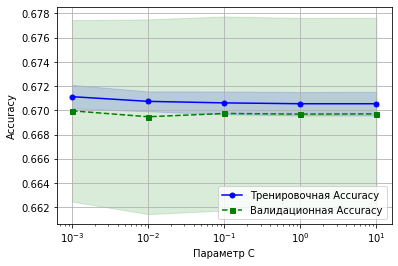

In [83]:
# Регуляризация типа l2 так же особо не повлияла, в итоге можно просто пользоваться моделью 2 без регуляризации
# Убедимся в этом, построив валидационную кривую для параметров, которые нашли через GridSearch
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(class_weight='balanced',
                                               penalty='l2',
                                               solver = 'lbfgs',
                                               random_state=RANDOM_SEED, 
                                               max_iter=MAX_ITER))])

param_range = [0.001, 0.01, 0.1, 1.0, 10]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Тренировочная Accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Валидационная Accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Параметр C')
plt.ylabel('Accuracy')

plt.show()

По графику видно, что параметр C и вообще регуляризация не влияют поведение модели

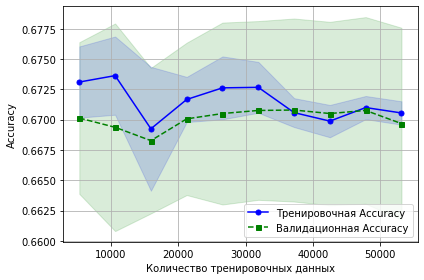

In [84]:
# И построим обучающую кривую для проверки смещения и разброса модели
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(class_weight='balanced',
                                               penalty='l2',
                                               solver = 'lbfgs',
                                               random_state=RANDOM_SEED, 
                                               max_iter=MAX_ITER))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Тренировочная Accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Валидационная Accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Количество тренировочных данных')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

Две кривые очень неплохо приближаются и, следовательно, модель не имеет смещения. Наблюдается довольно ощутимая дисперсия у валидационных данных, но в целом кривые хорошо сближаются.

Вывод: регуляризация не принесла значимых изменений. 

## 4.4 Проверка значимости столбцов для модели

In [85]:
# Проверим важность столбцов несколькими способами.
# Проверять будем на модели, которую посоветовал поиск.
# Но сначала очистим наш накопитель оценок модели и прогоним модель с балансировкой заново
metrics = pd.DataFrame(columns=['model','param','TP','TN','FP','FN', 
                              'accuracy','balanced_accuracy', 'precision','recall','f1','roc_auc'])
model5 = LogisticRegression(class_weight='balanced',
                            penalty='l2',
                            C=1,
                            solver = 'lbfgs',
                            random_state=RANDOM_SEED, 
                            max_iter=MAX_ITER)

model5.fit(X_train, y_train)

y_pred = model5.predict(X_test)

probs = model5.predict_proba(X_test)
probs = probs[:,1]

metrics = add_model_metrics(metrics, 'm5', ['balanced','l2','1'], y_test, y_pred, y_pred_prob)
metrics

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033


In [86]:
# И добавим для сравнения модель для первого варианта регуляризации
model6 = LogisticRegression(class_weight='balanced',
                            penalty='l1',
                            C=1,
                            solver = 'liblinear',
                            random_state=RANDOM_SEED, 
                            max_iter=MAX_ITER)

model6.fit(X_train, y_train)

y_pred = model6.predict(X_test)

probs = model6.predict_proba(X_test)
probs = probs[:,1]

metrics = add_model_metrics(metrics, 'm6', ['balanced','l1','1'], y_test, y_pred, y_pred_prob)
metrics

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
1,m6,"[balanced, l1, 1]",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033


Модели отличаются не очень сильно.

In [87]:
col_cnt = len(X_train.columns)

In [88]:
# 1 способ:  проверим коэффициенты в построенной модели 
df_coef = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(col_cnt,1), 
                                  model5.coef_.reshape(col_cnt,1))), columns = ['col', 'coef'])
df_coef = df_coef.set_index('col')
df_coef.coef = np.abs(df_coef.coef)

display(df_coef[df_coef.coef==0].coef.sort_values())
display(df_coef[df_coef.coef>0].coef.sort_values())

Series([], Name: coef, dtype: object)

col
app_week_4          0.000436676
app_hol               0.0118429
income                0.0137842
cat_age_0              0.018039
edu_2                 0.0184062
                       ...     
region_rating_80       0.430618
work_address_2          0.45688
reg_7080               0.500475
region_rating_20       0.551482
score_bki               0.97218
Name: coef, Length: 71, dtype: object

In [89]:
# Отбросим нулевую часть столбцов - на Kaggle они были, но тут почему-то все столбцы имеют коэффициенты > 0

# notnull_cols = df_coef[df_coef.coef>0].index - это было на Kaggle. А здесь отбросим столбцы с малыми коэфф.
notnull_cols = df_coef[df_coef.coef>0.01].index
X_train_1 = X_train[notnull_cols]
X_test_1 = X_test[notnull_cols]

model5.fit(X_train_1, y_train)

y_pred = model5.predict(X_test_1)
probs = model5.predict_proba(X_test_1)
probs = probs[:,1]

metrics = add_model_metrics(metrics, 'm5-a', ['coeff 0'], y_test, y_pred, y_pred_prob)
metrics

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
1,m6,"[balanced, l1, 1]",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
2,m5-a,[coeff 0],1267,8636,4297,560,0.670935,0.680618,0.227714,0.693487,0.342849,0.745033


Train ROC AUC: mean=0.7499, std=0.0016
Test ROC AUC: mean=0.7395, std=0.0141


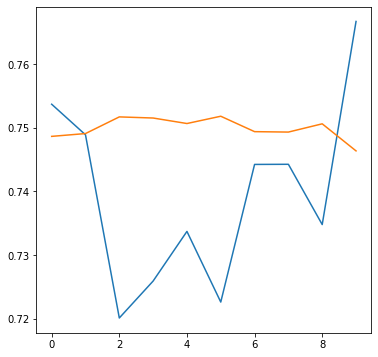

In [90]:
# Видно, что отбрасывание нулевых столбцов не изменило модель
# Проведем кросс-валидацию этой упрощенной модели
temp_vec = cross_validate(model5, X_test_1, y_test, cv=10, scoring='roc_auc', return_train_score=True)

arr_test = temp_vec['test_score']
arr_train = temp_vec['train_score']

print('Train ROC AUC: mean={:0.4f}'.format(np.mean(arr_train)) + ", std={:1.4f}".format(np.std(arr_train))) 
print('Test ROC AUC: mean={:0.4f}'.format(np.mean(arr_test)) + ", std={:1.4f}".format(np.std(arr_test))) 

plt.figure(figsize=(6, 6))
plt.plot(range(10),temp_vec['test_score'])
plt.plot(range(10),temp_vec['train_score'])

Разброс на тестовой части по-прежнему большой

In [91]:
# 2 способ отбора: RFE. Подставим все признаки, которые сейчас есть
rfe = RFE(model5, col_cnt)
rfe = rfe.fit(X_train, y_train)

df_imp = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(col_cnt,1), 
                                  rfe.support_.reshape(col_cnt,1))), columns = ['col', 'important'])
df_imp[df_imp.important==False]

,col,important


Все признаки вышли важными. Ничего отбрасывать нельзя

score_bki           0.083421
age                 0.067073
income              0.064200
bki_request_cnt     0.058857
rate                0.057108
                      ...   
edu_4               0.001659
region_rating_20    0.001522
home_address_3      0.001392
cat_addr_6          0.001203
edu_5               0.000300
Length: 71, dtype: float64

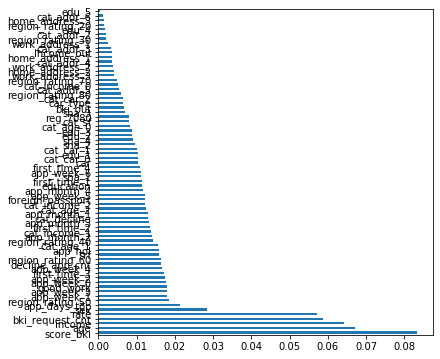

In [92]:
# 3 способ отбора: ExtraTreesClassifier. 
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

df_importance = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(col_cnt,1), 
                                  model.feature_importances_.reshape(col_cnt,1))), columns = ['col', 'imp'])

plt.rcParams['figure.figsize'] = (6,6)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(col_cnt).plot(kind='barh')
feat_importances.nlargest(col_cnt)

In [93]:
# Попробуем удалить другие столбцы - те, что в ExtraTreesClassifier меньше 0.01
imp_cols = feat_importances[feat_importances>0.01].index
X_train_3 = X_train[imp_cols]
X_test_3 = X_test[imp_cols]

model5.fit(X_train_3, y_train)

y_pred = model5.predict(X_test_3)
probs = model5.predict_proba(X_test_3)
probs = probs[:,1]

metrics = add_model_metrics(metrics, 'm5-c', ['ETC'], y_test, y_pred, y_pred_prob)
display(metrics)

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
1,m6,"[balanced, l1, 1]",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
2,m5-a,[coeff 0],1267,8636,4297,560,0.670935,0.680618,0.227714,0.693487,0.342849,0.745033
3,m5-c,[ETC],1205,8466,4467,622,0.655217,0.657078,0.212447,0.659551,0.321376,0.745033


Видно, что удаление этих столбцов ухудшило модель: комплексная метрика f1 уменьшилась

In [94]:
# 4 способ отбора: метод главных компонент. Оставим 20 признаков
pca = PCA(n_components=20)
X_train_4 = pca.fit_transform(X_train)
X_test_4 = pca.transform(X_test)

model5.fit(X_train_4, y_train)

y_pred = model5.predict(X_test_4)
probs = model5.predict_proba(X_test_4)
probs = probs[:,1]

metrics = add_model_metrics(metrics, 'm5-d', ['PCA'], y_test, y_pred, y_pred_prob)
display(metrics)

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
1,m6,"[balanced, l1, 1]",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
2,m5-a,[coeff 0],1267,8636,4297,560,0.670935,0.680618,0.227714,0.693487,0.342849,0.745033
3,m5-c,[ETC],1205,8466,4467,622,0.655217,0.657078,0.212447,0.659551,0.321376,0.745033
4,m5-d,[PCA],1214,8584,4349,613,0.663821,0.664103,0.218228,0.664477,0.328552,0.745033


Видно, что снова метрики f1 и recall ухудшились, но в целом существенно ничего не изменилось

In [95]:
# 5 способ отбора: SelectKBest
# Для этого метода нужно, чтобы все значения были неотрицательными
min_sbki = abs(X['score_bki'].min())
X['score_bki'] = X['score_bki'] + min_sbki

skb = SelectKBest(chi2, k=15)
skb.fit(X, y)

X_5 = skb.transform(X)
X_5.shape

imp_cols = X.columns[skb.get_support(indices=True)].tolist()
X_train_5 = X_train[imp_cols]
X_test_5 = X_test[imp_cols]

model5.fit(X_train_5, y_train)

y_pred = model5.predict(X_test_5)
probs = model5.predict_proba(X_test_5)
probs = probs[:,1]

metrics = add_model_metrics(metrics, 'm5-e', ['SelectKBest'], y_test, y_pred, y_pred_prob)
display(metrics)

# Видно, что отбор признаков не имел значения. Можно только отбросить столбцы с нулевыми коэффициентами.
# Простая модель с балансировкой и со всеми признаками - это лучший вариант

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
1,m6,"[balanced, l1, 1]",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
2,m5-a,[coeff 0],1267,8636,4297,560,0.670935,0.680618,0.227714,0.693487,0.342849,0.745033
3,m5-c,[ETC],1205,8466,4467,622,0.655217,0.657078,0.212447,0.659551,0.321376,0.745033
4,m5-d,[PCA],1214,8584,4349,613,0.663821,0.664103,0.218228,0.664477,0.328552,0.745033
5,m5-e,[SelectKBest],1234,8527,4406,593,0.661314,0.667373,0.218794,0.675424,0.330521,0.745033


Вывод: отбор признаков не имел значения. 
Модель с балансировкой и со всеми признаками - это лучший вариант

# 5. Применение Undersampling и OverSampling

Воспользуемся другим методом побора модели: 
выравнивание классов методами UnderSampling и OverSsampling

In [96]:
# UnderSampling - случайное удаление экземпляров избыточного класса
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_under, y_under = rus.fit_resample(X, y)

y_under.shape

(18744,)

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
1,m6,"[balanced, l1, 1]",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
2,m5-a,[coeff 0],1267,8636,4297,560,0.670935,0.680618,0.227714,0.693487,0.342849,0.745033
3,m5-c,[ETC],1205,8466,4467,622,0.655217,0.657078,0.212447,0.659551,0.321376,0.745033
4,m5-d,[PCA],1214,8584,4349,613,0.663821,0.664103,0.218228,0.664477,0.328552,0.745033
5,m5-e,[SelectKBest],1234,8527,4406,593,0.661314,0.667373,0.218794,0.675424,0.330521,0.745033
6,m_under,[UnderSampling],1264,1262,625,598,0.673780,0.673813,0.669137,0.678840,0.673954,0.738053


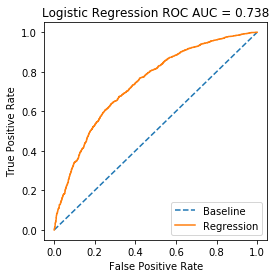

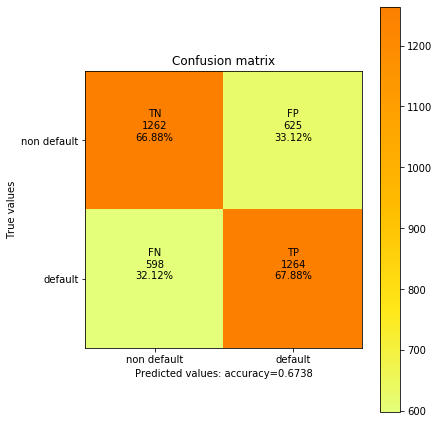

In [97]:
# Строим подобранную ранее модель на обрезанных данных
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.20, random_state=RANDOM_SEED)

model5.fit(X_train, y_train)

y_pred = model5.predict(X_test)
probs = model5.predict_proba(X_test)
y_pred_prob = probs[:,1]

metrics = add_model_metrics(metrics, 'm_under', ['UnderSampling'], y_test, y_pred, y_pred_prob)
display(metrics)
graph_roc_auc(y_test, y_pred_prob)
graph_confusion_matrix(y_test, y_pred)

Метрика ROC AUC немного ухудшилась, но зато f1 улучшилась в 2 раза! 

In [98]:
# OverSampling - добавление экземпляров недостаточного класса
ros = RandomOverSampler(random_state=0)
X_over, y_over = ros.fit_resample(X, y)

y_over.shape

(128854,)

,model,param,TP,TN,FP,FN,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,m5,"[balanced, l2, 1]",1267,8637,4296,560,0.671003,0.680657,0.227755,0.693487,0.342896,0.745033
1,m6,"[balanced, l1, 1]",1264,8643,4290,563,0.671206,0.680067,0.227584,0.691845,0.342501,0.745033
2,m5-a,[coeff 0],1267,8636,4297,560,0.670935,0.680618,0.227714,0.693487,0.342849,0.745033
3,m5-c,[ETC],1205,8466,4467,622,0.655217,0.657078,0.212447,0.659551,0.321376,0.745033
4,m5-d,[PCA],1214,8584,4349,613,0.663821,0.664103,0.218228,0.664477,0.328552,0.745033
5,m5-e,[SelectKBest],1234,8527,4406,593,0.661314,0.667373,0.218794,0.675424,0.330521,0.745033
6,m_under,[UnderSampling],1264,1262,625,598,0.673780,0.673813,0.669137,0.678840,0.673954,0.738053
7,m_over,[OverSampling],8710,8634,4243,4184,0.673005,0.673003,0.672431,0.675508,0.673966,0.739059


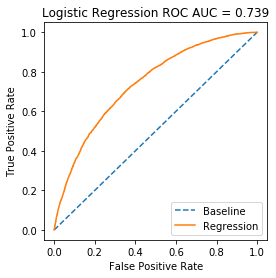

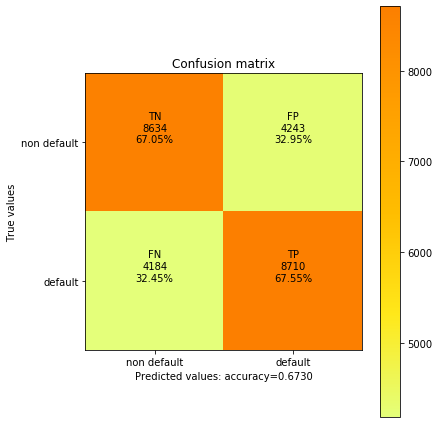

In [99]:
# Строим подобранную ранее модель на добавленных данных
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.20, random_state=RANDOM_SEED)

model5.fit(X_train, y_train)

y_pred = model5.predict(X_test)
probs = model5.predict_proba(X_test)
y_pred_prob = probs[:,1]

metrics = add_model_metrics(metrics, 'm_over', ['OverSampling'], y_test, y_pred, y_pred_prob)
display(metrics)
graph_roc_auc(y_test, y_pred_prob)
graph_confusion_matrix(y_test, y_pred)

Метрика ROC AUC тоже хуже базовой, но f1 еще улучшилась.

С точки зрения соревнований брать эту модель не стоит, но с точки зрения здравого смысла - это пока наилучший результат, так как метрика f1 выросла в 2 раза, при том, что ROC AUC ухудшилась всего лишь на тысячные доли.

# 6. Submission

In [100]:
# Заново формируем тренировочную и тестовую части данных
train_data = data[data['sample']==1].drop(['sample'], axis=1)
test_data = data[data['sample']==0].drop(['sample'], axis=1)

# Подготовка
X_train = train_data.drop(['default'], axis=1)
y_train = train_data['default'] 
X_test = test_data.drop(['default'], axis=1)

# Заново берем столбцы с ненулевыми коэффициентами
# X_train = X_train[notnull_cols] 
# X_test = X_test[notnull_cols]   
 
# Проверка
print(test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape)

# Модель 
model5.fit(X_train, y_train)
y_pred_prob = model5.predict_proba(X_test)[:,1]

# Сохранение результата
submit = pd.DataFrame(df_test['client_id'])
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

submit.head(5)

(36349, 72) (73799, 72) (73799, 71) (73799,) (36349, 71)


,client_id,default
0,74835,0.208770
1,17527,0.755019
2,75683,0.353792
3,26883,0.370279
4,28862,0.138347
